##Imports

In [73]:
import glob
import cv2
import math
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline

##Loading and visualisation of training data

In [40]:
vehicle_data = np.array( glob.glob("./data/vehicles/**/*.png") )
non_vehicle_data = np.array( glob.glob("./data/non-vehicles/**/*.png") )
print('Vehicles loaded: {0}'.format(len(vehicle_data)))
print('Non-vehicles loaded: {0}'.format(len(non_vehicle_data)))

Vehicles loaded: 8792
Non-vehicles loaded: 8968


In [69]:
def visualise_images(images):
    fig, axs = plt.subplots(
        nrows=math.ceil(len(images) / 5),
        ncols=5,
        figsize=(16,16)
    )
    axs = axs.ravel()
    
    for image, ax in zip(images, axs):
        ax.imshow(image)

def load_images(images_paths):
    return [
        cv2.cvtColor(
            cv2.imread(image_path),
            cv2.COLOR_BGR2RGB
        )
        for image_path in images_paths
    ]

def sample(images, sample_size):
    return images[ np.random.choice(np.arange(len(images)), sample_size) ]

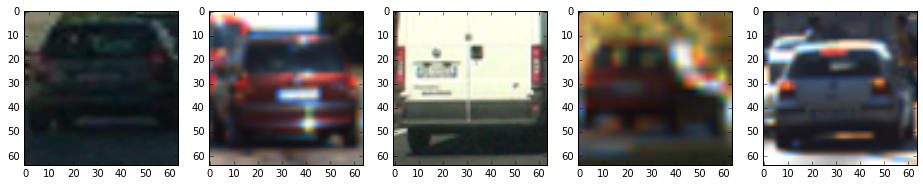

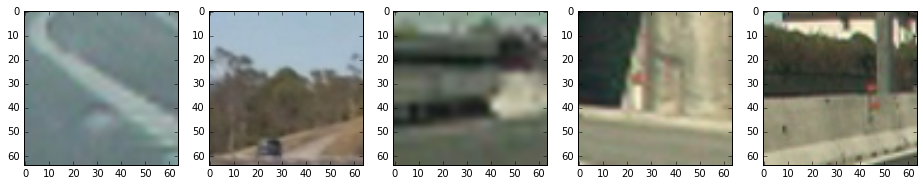

In [71]:
visualise_images(load_images(sample(vehicle_data, 5)))
visualise_images(load_images(sample(non_vehicle_data, 5)))

##Histogram of Gradients

In [75]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  # block_norm= 'L2-Hys', 
                                  transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

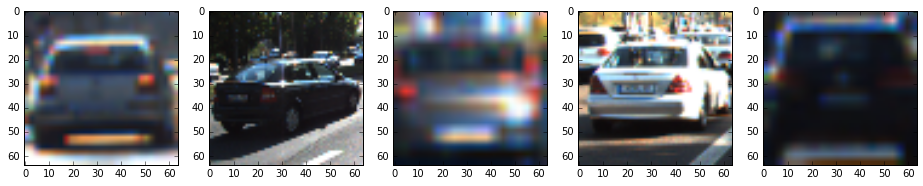

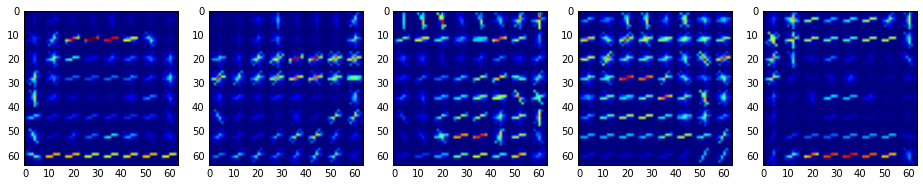

In [83]:
vehicles_sample = sample(vehicle_data, 5)
hog_vehicle_sample = [
    get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)[1]
    for img in load_images(vehicles_sample)
]

visualise_images(load_images(vehicles_sample))
visualise_images(hog_vehicle_sample)